## Load data

In [7]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [8]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow512cleaned/'

In [10]:
ext = '.npy'
X_train = np.load(datapath+'X_train'+ext)
y_train_binary = np.load(datapath+'y_train_binary'+ext)
X_val = np.load(datapath+'X_val'+ext)
y_val_binary = np.load(datapath+'y_val_binary'+ext)
X_test = np.load(datapath+'X_test'+ext)
y_test_binary = np.load(datapath+'y_test_binary'+ext)

In [11]:
num_classes = y_train_binary.shape[1]
print(num_classes)

12


## Generate models

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [13]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [14]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  max_layers=4
                                 )

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.2 s


In [15]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([84]), 'fc_hidden_nodes': 52, 'regularization_rate': 0.005566760097081618, 'learning_rate': 0.039757717258914554}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNormal(None, 512, 9)        18          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 512, 84)       2352        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512, 84)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 43008)         0    

## Compare models

In [16]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subset_size=500,
                                                                                  verbose=True)

Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 6s - loss: 67.7692 - acc: 0.1980 - val_loss: 14.2629 - val_acc: 0.1151
Epoch 2/5
500/500 [==============================] - 6s - loss: 21.5274 - acc: 0.1140 - val_loss: 14.2390 - val_acc: 0.1151
Epoch 3/5
500/500 [==============================] - 7s - loss: 21.5696 - acc: 0.0480 - val_loss: 16.0217 - val_acc: 0.0060
Epoch 4/5
500/500 [==============================] - 6s - loss: 68.3452 - acc: 0.0460 - val_loss: 16.0217 - val_acc: 0.0060
Epoch 5/5
500/500 [==============================] - 7s - loss: 32.6940 - acc: 0.0460 - val_loss: 16.0217 - val_acc: 0.0060
Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 6s - loss: 3.8855 - acc: 0.4680 - val_loss: 0.8864 - val_acc: 0.7703
Epoch 2/5
500/500 [==============================] - 8s - loss: 1.4117 - acc: 0.7520 - val_loss: 0.7249 - val_acc: 0.7982
Epoch 3/5
500/500 [=======================

CPU times: user 1.31 s, sys: 0 ns, total: 1.31 s
Wall time: 1.35 s


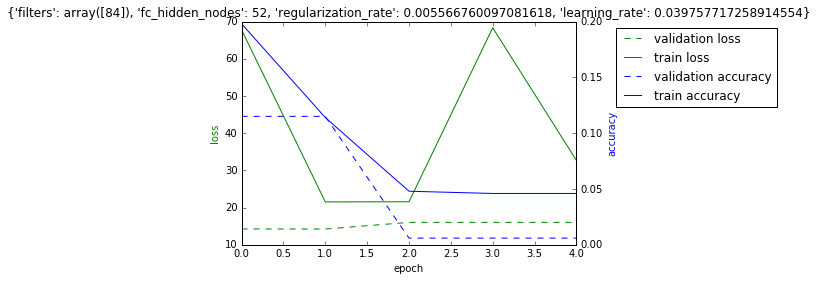

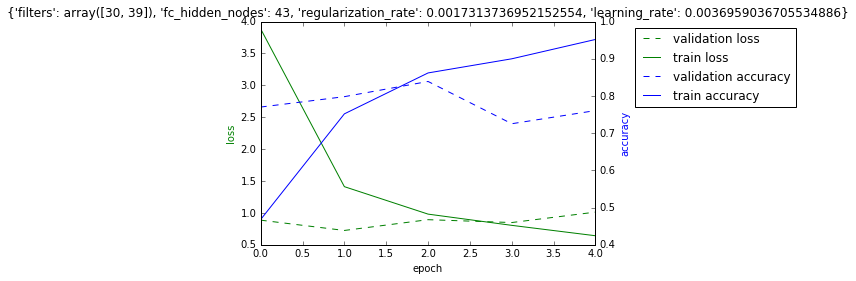

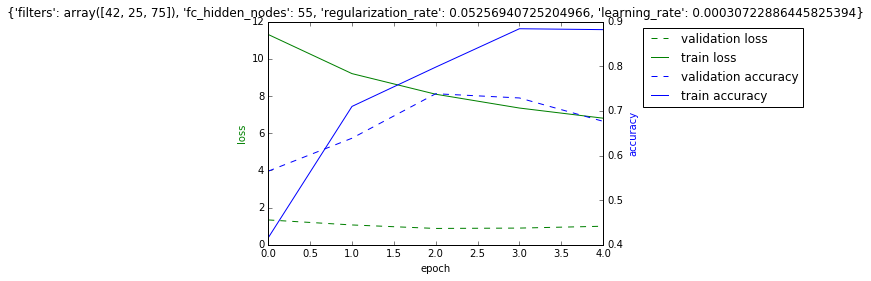

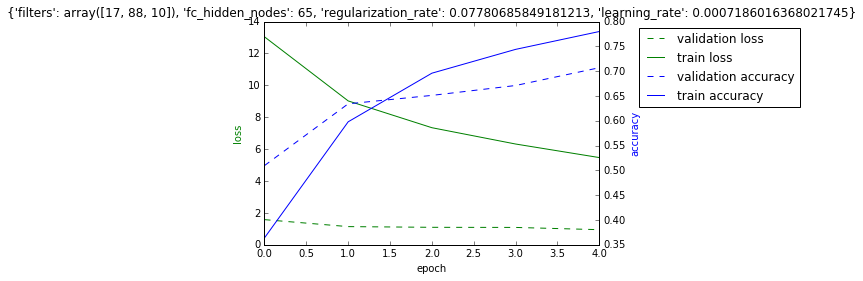

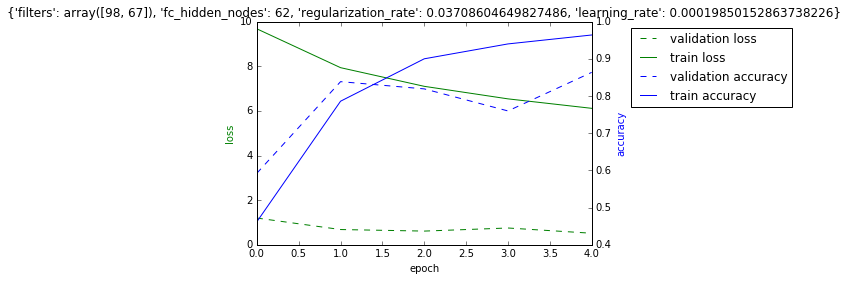

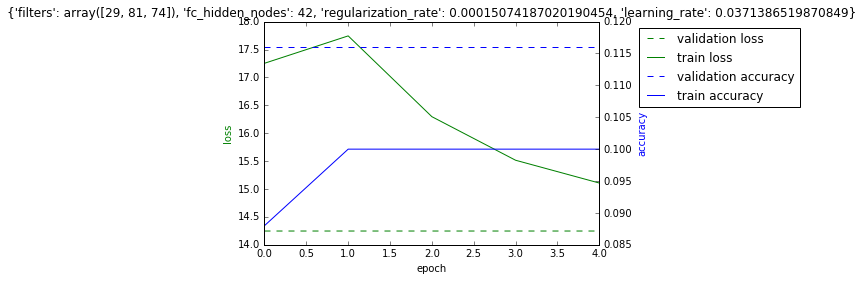

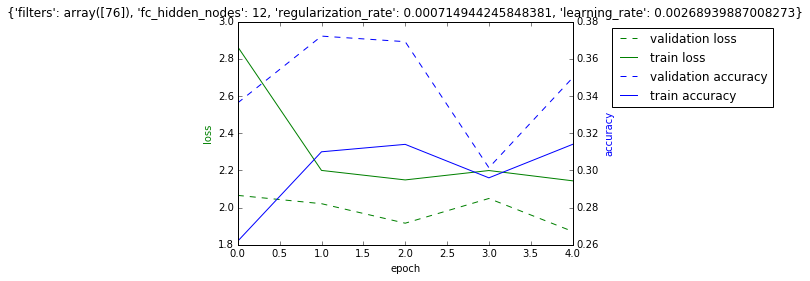

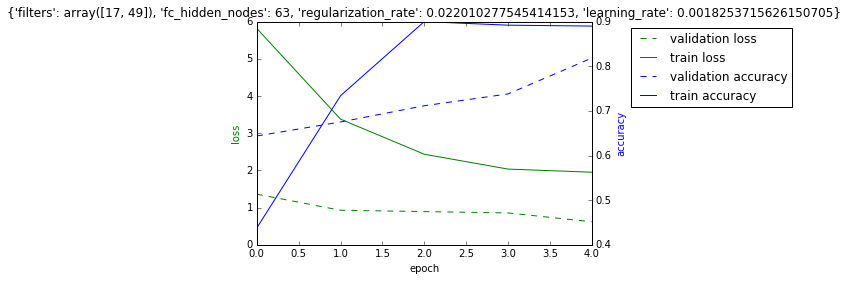

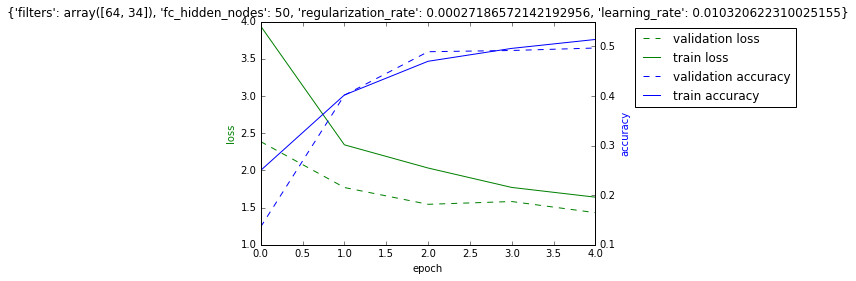

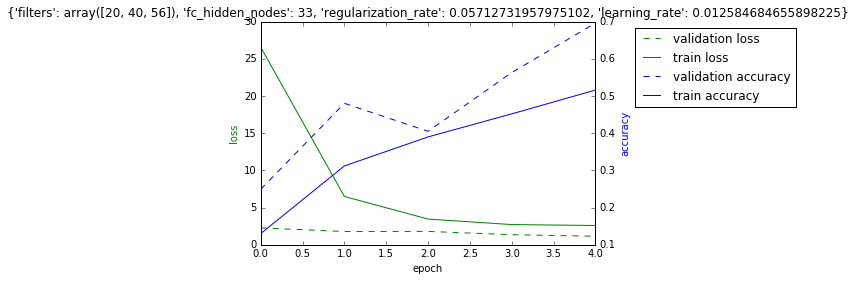

In [17]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [18]:
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([84]), 'fc_hidden_nodes': 52...",0.046,32.694049,0.005979,16.021724
1,"{'filters': array([30, 39]), 'fc_hidden_nodes'...",0.952,0.642059,0.760837,1.012751
2,"{'filters': array([42, 25, 75]), 'fc_hidden_no...",0.882,6.807336,0.676632,0.998042
3,"{'filters': array([17, 88, 10]), 'fc_hidden_no...",0.780,5.471380,0.707025,0.947912
4,"{'filters': array([98, 67]), 'fc_hidden_nodes'...",0.964,6.114465,0.863478,0.518015
5,"{'filters': array([29, 81, 74]), 'fc_hidden_no...",0.100,15.106955,0.116094,14.246927
6,"{'filters': array([76]), 'fc_hidden_nodes': 12...",0.314,2.144053,0.349776,1.871942
7,"{'filters': array([17, 49]), 'fc_hidden_nodes'...",0.890,1.950899,0.818137,0.619544
8,"{'filters': array([64, 34]), 'fc_hidden_nodes'...",0.514,1.639919,0.496761,1.431682
9,"{'filters': array([20, 40, 56]), 'fc_hidden_no...",0.516,2.592982,0.696064,1.151553


In [20]:
results.to_csv(datapath+'results.csv')

## Train the best model for real

In [21]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [22]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

4 CNN {'filters': array([98, 67]), 'fc_hidden_nodes': 62, 'regularization_rate': 0.03708604649827486, 'learning_rate': 0.00019850152863738226}


We make a copy of the model, to start training from fresh.

In [74]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])

In [67]:
# We can set some backend options to avoid NaNs
print(K.floatx())
print(K.epsilon())
K.set_epsilon(1e-5)

float32
1e-16


We're going to train the model on the complete data set, and save the model after each epoch

In [72]:
nr_epochs = 5 #10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), 
                              callbacks=[keras.callbacks.ModelCheckpoint(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5')])

Train on 12497 samples, validate on 2007 samples
Epoch 1/5
12497/12497 [==============================] - 138s - loss: 6.0042 - acc: 0.8612 - val_loss: 0.2805 - val_acc: 0.9322
Epoch 2/5
12497/12497 [==============================] - 140s - loss: 3.2779 - acc: 0.9344 - val_loss: 0.2658 - val_acc: 0.9317
Epoch 3/5
12497/12497 [==============================] - 155s - loss: 2.1174 - acc: 0.9353 - val_loss: 0.2791 - val_acc: 0.9287
Epoch 4/5
12497/12497 [==============================] - 170s - loss: 1.4627 - acc: 0.9394 - val_loss: 0.2187 - val_acc: 0.9362
Epoch 5/5
12497/12497 [==============================] - 218s - loss: nan - acc: 0.5359 - val_loss: nan - val_acc: 0.1151


If we plot the training process, we see that the model is probably already overfitting in the first epoch. 

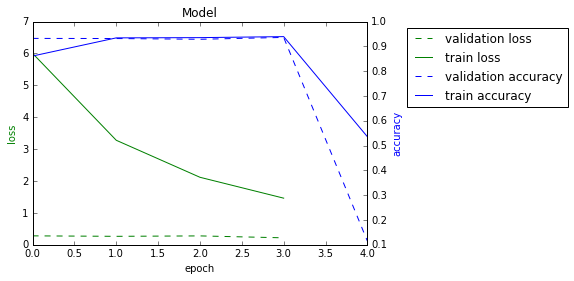

In [73]:
find_architecture.plotTrainingProcess(history)

In [76]:
#Load model from the  just before we get the NaNs
model_copy = keras.models.copy.copy(best_model_copy)
model_copy.load_weights(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5'.format(epoch=3, val_loss=0.22))
model_copy.compile(best_model_copy.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model_copy.evaluate(X_train, y_train_binary)

12497/12497 [==============================] - 100s   


[0.17593351770226665, 0.96871249099783951]

## Inspect model predictions

In [78]:
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs

2007/2007 [==============================] - 53s    


array([[  9.96852517e-01,   2.25957949e-03,   6.83049928e-09, ...,
          2.39043184e-05,   8.74882880e-06,   6.42670842e-04],
       [  9.96783733e-01,   2.32967618e-03,   6.68127242e-09, ...,
          2.32075290e-05,   8.67394738e-06,   6.47695037e-04],
       [  9.96741891e-01,   2.37100990e-03,   6.61404664e-09, ...,
          2.27409728e-05,   8.74455418e-06,   6.54084259e-04],
       ..., 
       [  1.07261769e-07,   2.62271325e-08,   3.49303404e-13, ...,
          2.91905326e-06,   2.34428637e-08,   1.10417325e-03],
       [  3.20605693e-07,   2.30440822e-08,   4.46437700e-13, ...,
          4.32447996e-06,   3.14905577e-08,   3.98514839e-03],
       [  2.58805084e-08,   1.29984796e-08,   3.77176182e-14, ...,
          8.23153755e-07,   2.07322359e-09,   1.71252832e-04]])

In [79]:
len(best_model.layers)

10

In [82]:
best_model_copy.layers[0].get_weights()

[array([ 1.05805969,  1.08182418,  1.05226934,  1.11985362,  1.11457896,
         1.08258474,  1.0675174 ,  1.09842944,  1.04272151], dtype=float32),
 array([-0.01621632,  0.00915477,  0.03112106, -0.00480812, -0.04024399,
         0.02938126,  0.02135731,  0.02876085,  0.02071398], dtype=float32),
 array([-5.03031445,  4.6670599 ,  3.88478112,  9.46627522,  0.05378294,
        -2.32858896,  0.26191753,  7.91399288, -1.74101698], dtype=float32),
 array([ 6.4479332 ,  6.31256723,  4.06258011,  6.53865671,  8.00042725,
         3.90192032,  1.78485167,  4.96417904,  4.87879181], dtype=float32)]

In [83]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]
layer_output

array([[[  9.14543152e-01,  -5.22749007e-01,   1.20961297e+00, ...,
           1.27866900e+00,  -1.36577868e+00,   2.07329273e+00],
        [  8.51596296e-01,  -4.23463970e-01,   1.41696489e+00, ...,
           9.61874366e-01,  -1.32358003e+00,   2.09593701e+00],
        [  8.29028249e-01,  -3.18831891e-01,   1.48567891e+00, ...,
           6.45163417e-01,  -1.36463904e+00,   2.12711763e+00],
        ..., 
        [  8.33073676e-01,  -5.33392504e-02,   1.30498242e+00, ...,
           3.66124213e-01,  -1.23794603e+00,   2.32352901e+00],
        [  8.69708896e-01,  -4.08081971e-02,   1.27587688e+00, ...,
           3.05379510e-01,  -1.22057402e+00,   2.41411233e+00],
        [  8.45695853e-01,  -8.58338997e-02,   1.32538247e+00, ...,
           3.95880163e-01,  -1.22073758e+00,   2.40642452e+00]],

       [[  8.95305097e-01,  -1.51136845e-01,   1.34682620e+00, ...,
           2.57436574e-01,  -1.26235223e+00,   2.38910627e+00],
        [  8.70019019e-01,  -1.90006688e-01,   1.33645797e+0

In [26]:
best_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNormal(None, 512, 9)        18          batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution1d_10 (Convolution1D) (None, 512, 98)       2744        batchnormalization_5[0][0]       
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 512, 98)       0           convolution1d_10[0][0]           
____________________________________________________________________________________________________
convolution1d_11 (Convolution1D) (None, 512, 67)       19765       activation_18[0][0]              
___________________________________________________________________________________________

In [84]:
score_val = best_model_copy.evaluate(X_val, y_val_binary, verbose=True)
score_val

2007/2007 [==============================] - 19s    


[0.21868674527978088, 0.93622321873442949]

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))